learning how to:

- determine which features are the most important with mutual information
- invent new features in several real-world problem domains
- encode high-cardinality categoricals with a target encoding
- create segmentation features with k-means clustering
- decompose a dataset's variation into features with principal component analysis

Tips on Creating Features

It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:

- Linear models learn sums and differences naturally, but can't learn anything more complex.
- Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
- Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
- Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
- Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

# Introduce

## The Goal of Feature Engineering

The goal of feature engineering is simply to make your data better suited to the problem at hand.

Consider "apparent temperature" measures like the heat index and the wind chill. These quantities attempt to measure the perceived temperature to humans based on air temperature, humidity, and wind speed, things which we can measure directly. You could think of an apparent temperature as the result of a kind of feature engineering, an attempt to make the observed data more relevant to what we actually care about: how it actually feels outside!

You might perform feature engineering to:

- improve a model's predictive performance
- reduce computational or data needs
- improve interpretability of the results


## A Guiding Principle of Feature Engineering¶
For a feature to be useful, it must have a relationship to the target that your model is able to learn. Linear models, for instance, are only able to learn linear relationships. So, when using a linear model, your goal is to transform the features to make their relationship to the target linear.

The key idea here is that a transformation you apply to a feature becomes in essence a part of the model itself. Say you were trying to predict the Price of square plots of land from the Length of one side. Fitting a linear model directly to Length gives poor results: the relationship is not linear.

If we square the Length feature to get 'Area', however, we create a linear relationship. Adding Area to the feature set means this linear model can now fit a parabola. Squaring a feature, in other words, gave the linear model the ability to fit squared features.

This should show you why there can be such a high return on time invested in feature engineering. Whatever relationships your model can't learn, you can provide yourself through transformations. As you develop your feature set, think about what information your model could use to achieve its best performance.

## Example 

To illustrate these ideas we'll see how adding a few synthetic features to a dataset can improve the predictive performance of a random forest model.

The Concrete dataset contains a variety of concrete formulations and the resulting product's compressive strength, which is a measure of how much load that kind of concrete can bear. The task for this dataset is to predict a concrete's compressive strength given its formulation.




In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv("/home/maciej/KURSY/Kaggle/pliki_pomoc/concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


You can see here the various ingredients going into each variety of concrete. We'll see in a moment how adding some additional synthetic features derived from these can help a model to learn important relationships among them.

We'll first establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful.

Establishing baselines like this is good practice at the start of the feature engineering process. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

In [2]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="mae", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:4

MAE Baseline Score: 8.232


If you ever cook at home, you might know that the ratio of ingredients in a recipe is usually a better predictor of how the recipe turns out than their absolute amounts. We might reason then that ratios of the features above would be a good predictor of CompressiveStrength.

The cell below adds three new ratio features to the dataset.

In [3]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="mae", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:4

MAE Score with Ratio Features: 7.948


# Mutual information

First encountering a new dataset can sometimes feel overwhelming. You might be presented with hundreds or thousands of features without even a description to go by. Where do you even begin?

A great first step is to construct a ranking with a feature utility metric, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:

- easy to use and interpret,
- computationally efficient,
- theoretically well-founded,
- resistant to overfitting, and,
- able to detect any kind of relationship


#### What it Measures

Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Here's an example from the Ames Housing data. The figure shows the relationship between the exterior quality of a house and the price it sold for. Each point represents a house.

Knowing the exterior quality of a house reduces uncertainty about its sale price.


From the figure, we can see that knowing the value of ExterQual should make you more certain about the corresponding SalePrice -- each category of ExterQual tends to concentrate SalePrice to within a certain range. The mutual information that ExterQual has with SalePrice is the average reduction of uncertainty in SalePrice taken over the four values of ExterQual. Since Fair occurs less often than Typical, for instance, Fair gets less weight in the MI score.


(Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.)

### Interpreting Mutual Information Scores

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

The next figure will give you an idea of how MI values correspond to the kind and degree of association a feature has with the target.

Here are some things to remember when applying mutual information:

- MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
- The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.


## Example

The Automobile dataset consists of 193 cars from the 1985 model year. The goal for this dataset is to predict a car's price (the target) from 23 of the car's features, such as make, body_style, and horsepower. In this example, we'll rank the features with mutual information and investigate the results by data visualization.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")

df = pd.read_csv("/home/maciej/KURSY/Kaggle/pliki_pomoc/autos.csv")
df.head()


,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that must have a float dtype is not discrete. Categoricals (object or categorial dtype) can be treated as discrete by giving them a label encoding. (You can review label encodings in our Categorical Variables lesson.)

In [5]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int


Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif). Our target, price, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [6]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb_weight          1.555416
highway_mpg          0.952817
length               0.622627
bore                 0.493857
stroke               0.379055
num_of_cylinders     0.332900
compression_ratio    0.133897
fuel_type            0.048139
Name: MI Scores, dtype: float64

And now a bar plot to make comparisions easier:

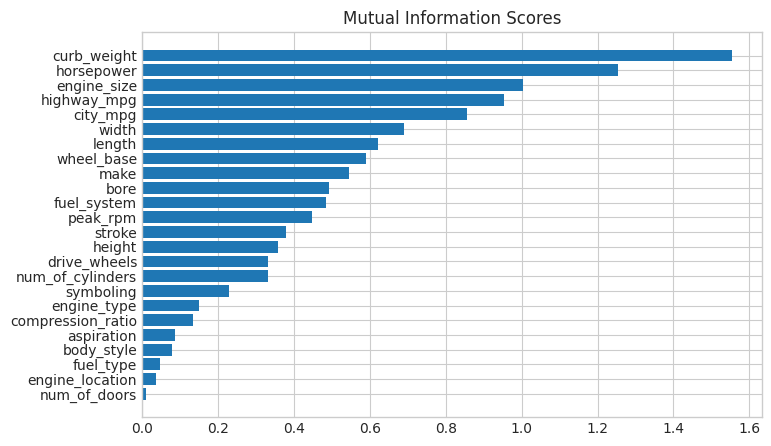

In [7]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

# Creating Features

Once you've identified a set of features with some potential, it's time to start developing them. In this lesson, you'll learn a number of common transformations you can do entirely in Pandas. If you're feeling rusty, we've got a great course on Pandas.


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

accidents = pd.read_csv("/home/maciej/KURSY/Kaggle/pliki_pomoc/accidents.csv")
autos = pd.read_csv("/home/maciej/KURSY/Kaggle/pliki_pomoc/automobile.csv")
concrete = pd.read_csv("/home/maciej/KURSY/Kaggle/pliki_pomoc/concrete.csv")
customer = pd.read_csv("/home/maciej/KURSY/Kaggle/pliki_pomoc/customer.csv")

Tips on Discovering New Features
- Understand the features. Refer to your dataset's data documentation, if available.
- Research the problem domain to acquire domain knowledge. If your problem is predicting house prices, do some research on real-estate for instance. Wikipedia can be a good starting point, but books and journal articles will often have the best information.
- Study previous work. Solution write-ups from past Kaggle competitions are a great resource.
- Use data visualization. Visualization can reveal pathologies in the distribution of a feature or complicated relationships that could be simplified. Be sure to visualize your dataset as you work through the feature engineering process.

# Mathematical Transforms

Relationships among numerical features are often expressed through mathematical formulas, which you'll frequently come across as part of your domain research. In Pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers.

In the Automobile dataset are features describing a car's engine. Research yields a variety of formulas for creating potentially useful new features. The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:



In [9]:
autos["stroke_ratio"] = autos.stroke / autos.bore

#autos.stroke = autos.stroke.astype(float)

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


The more complicated a combination is, the more difficult it will be for a model to learn, like this formula for an engine's "displacement", a measure of its power:

In [10]:
autos["displacement"] = (
    np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos.num_of_cylinders
)


AttributeError: 'DataFrame' object has no attribute 'num_of_cylinders'

Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of WindSpeed in US Accidents is highly skewed, for instance. In this case the logarithm is effective at normalizing it:

In [ ]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);

## Counts

Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. You can aggregate such features by creating a count.

These features will be binary (1 for Present, 0 for Absent) or boolean (True or False). In Python, booleans can be added up just as if they were integers.

In Traffic Accidents are several features indicating whether some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the sum method:

In [ ]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)


You could also use a dataframe's built-in methods to create boolean values. In the Concrete dataset are the amounts of components in a concrete formulation. Many formulations lack one or more components (that is, the component has a value of 0). This will count how many components are in a formulation with the dataframe's built-in greater-than gt method:

In [ ]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


## Building-Up and Breaking-Down Features


Often you'll have complex strings that can usefully be broken into simpler pieces. Some common examples:

- ID numbers: '123-45-6789'
- Phone numbers: '(999) 555-0123'
- Street addresses: '8241 Kaggle Ln., Goose City, NV'
- Internet addresses: 'http://www.kaggle.com
- Product codes: '0 36000 29145 2'
- Dates and times: 'Mon Sep 30 07:06:05 2013'

Features like these will often have some kind of structure that you can make use of. US phone numbers, for instance, have an area code (the '(999)' part) that tells you the location of the caller. As always, some research can pay off here.

The str accessor lets you apply string methods like split directly to columns. The Customer Lifetime Value dataset contains features describing customers of an insurance company. From the Policy feature, we could separate the Type from the Level of coverage:

In [ ]:
customer[["Type", "Level"]] = (  # Create two new features
    customer["Policy"]           # from the Policy feature
    .str                         # through the string accessor
    .split(" ", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)

customer[["Policy", "Type", "Level"]].head(10)


You could also join simple features into a composed feature if you had reason to believe there was some interaction in the combination:



In [ ]:
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()


Elsewhere on Kaggle Learn
There are a few other kinds of data we haven't talked about here that are especially rich in information. Fortunately, we've got you covered!

- For dates and times, see Parsing Dates from our Data Cleaning course.

- For latitudes and longitudes, see our Geospatial Analysis course.

## Group Transform

Finally we have Group transforms, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like: "the average income of a person's state of residence," or "the proportion of movies released on a weekday, by genre." If you had discovered a category interaction, a group transform over that categry could be something good to investigate.

Using an aggregation function, a group transform combines two features: a categorical feature that provides the grouping and another feature whose values you wish to aggregate. For an "average income by state", you would choose State for the grouping feature, mean for the aggregation function, and Income for the aggregated feature. To compute this in Pandas, we use the groupby and transform methods:

In [ ]:
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

customer[["State", "Income", "AverageIncome"]].head(10)

The mean function is a built-in dataframe method, which means we can pass it as a string to transform. Other handy methods include max, min, median, var, std, and count. Here's how you could calculate the frequency with which each state occurs in the dataset:

In [ ]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]].head(10)


NameError: name 'customer' is not defined

You could use a transform like this to create a "frequency encoding" for a categorical feature.

If you're using training and validation splits, to preserve their independence, it's best to create a grouped feature using only the training set and then join it to the validation set. We can use the validation set's merge method after creating a unique set of values with drop_duplicates on the training set:

In [ ]:
# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)


Tips on Creating Features

It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:

- Linear models learn sums and differences naturally, but can't learn anything more complex.
- Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
- Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
- Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
- Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

# Clustering With K-Means

This lesson and the next make use of what are known as unsupervised learning algorithms. Unsupervised algorithms don't make use of a target; instead, their purpose is to learn some property of the data, to represent the structure of the features in a certain way. In the context of feature engineering for prediction, you could think of an unsupervised algorithm as a "feature discovery" technique.

Clustering simply means the assigning of data points to groups based upon how similar the points are to each other. A clustering algorithm makes "birds of a feather flock together," so to speak.

When used for feature engineering, we could attempt to discover groups of customers representing a market segment, for instance, or geographic areas that share similar weather patterns. Adding a feature of cluster labels can help machine learning models untangle complicated relationships of space or proximity.

for better visualisation : https://www.kaggle.com/code/ryanholbrook/clustering-with-k-means


             Mathematics, the Euclidean distance is defined as the distance between two points. In other words, the Euclidean distance between two points in the Euclidean space is defined as the length of the line segment between two points.

There are a great many clustering algorithms. They differ primarily in how they measure "similarity" or "proximity" and in what kinds of features they work with. The algorithm we'll use, k-means, is intuitive and easy to apply in a feature engineering context. Depending on your application another algorithm might be more appropriate.

K-means clustering measures similarity using ordinary straight-line distance (Euclidean distance, in other words). It creates clusters by placing a number of points, called centroids, inside the feature-space. Each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in "k-means" is how many centroids (that is, clusters) it creates. You define the k yourself.

You could imagine each centroid capturing points through a sequence of radiating circles. When sets of circles from competing centroids overlap they form a line. The result is what's called a Voronoi tessallation. The tessallation shows you to what clusters future data will be assigned; the tessallation is essentially what k-means learns from its training data.

The clustering on the Ames dataset above is a k-means clustering. Here is the same figure with the tessallation and centroids shown.


Let's review how the k-means algorithm learns the clusters and what that means for feature engineering. We'll focus on three parameters from scikit-learn's implementation: n_clusters, max_iter, and n_init.

It's a simple two-step process. The algorithm starts by randomly initializing some predefined number (n_clusters) of centroids. It then iterates over these two operations:

1. assign points to the nearest cluster centroid
2. move each centroid to minimize the distance to its points

It iterates over these two steps until the centroids aren't moving anymore, or until some maximum number of iterations has passed (max_iter).

It often happens that the initial random position of the centroids ends in a poor clustering. For this reason the algorithm repeats a number of times (n_init) and returns the clustering that has the least total distance between each point and its centroid, the optimal clustering.

The animation below shows the algorithm in action. It illustrates the dependence of the result on the initial centroids and the importance of iterating until convergence.


 You may need to increase the max_iter for a large number of clusters or n_init for a complex dataset. Ordinarily though the only parameter you'll need to choose yourself is n_clusters (k, that is). The best partitioning for a set of features depends on the model you're using and what you're trying to predict, so it's best to tune it like any hyperparameter (through cross-validation, say).



## example

As spatial features, California Housing's 'Latitude' and 'Longitude' make natural candidates for k-means clustering. In this example we'll cluster these with 'MedInc' (median income) to create economic segments in different regions of California.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

df = pd.read_csv("/home/maciej/KURSY/Kaggle/pliki_pomoc/california.csv")
X = df.loc[:, ["median_income", "latitude", "longitude"]]
X.head()

,median_income,latitude,longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


Since k-means clustering is sensitive to scale, it can be a good idea rescale or normalize data with extreme values. Our features are already roughly on the same scale, so we'll leave them as-is.

In [ ]:
# Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,median_income,latitude,longitude,Cluster
0,8.3252,37.88,-122.23,4
1,8.3014,37.86,-122.22,4
2,7.2574,37.85,-122.24,4
3,5.6431,37.85,-122.25,4
4,3.8462,37.85,-122.25,0


Now let's look at a couple plots to see how effective this was. First, a scatter plot that shows the geographic distribution of the clusters. It seems like the algorithm has created separate segments for higher-income areas on the coasts.



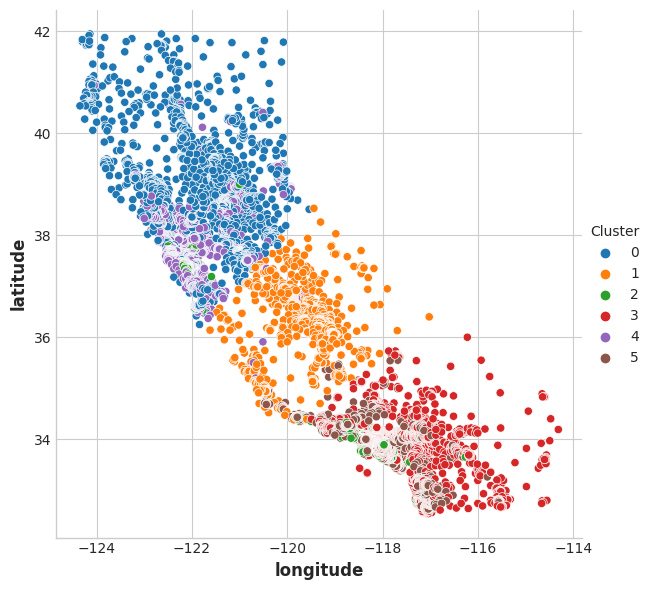

In [ ]:
sns.relplot(
    x="longitude", y="latitude", hue="Cluster", data=X, height=6,
)


The target in this dataset is MedHouseVal (median house value). These box-plots show the distribution of the target within each cluster. If the clustering is informative, these distributions should, for the most part, separate across MedHouseVal, which is indeed what we see.



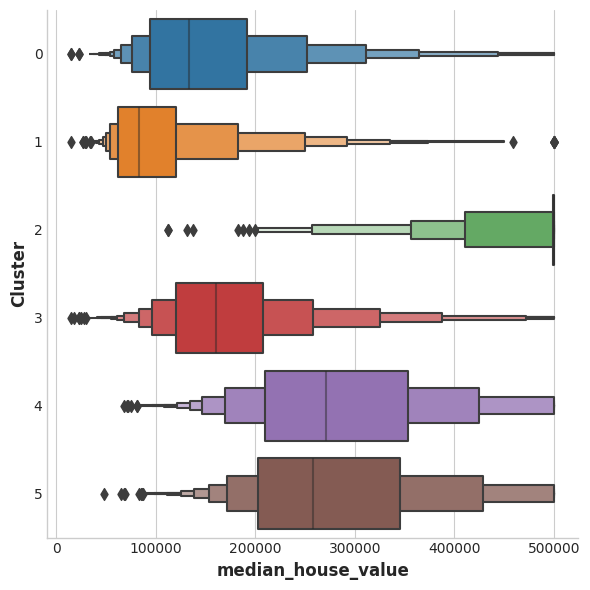

In [ ]:
X["median_house_value"] = df["median_house_value"]
sns.catplot(x="median_house_value", y="Cluster", data=X, kind="boxen", height=6);

# Principal Component Analysis

In the previous lesson we looked at our first model-based method for feature engineering: clustering. In this lesson we look at our next: principal component analysis (PCA). Just like clustering is a partitioning of the dataset based on proximity, you could think of PCA as a partitioning of the variation in the data. PCA is a great tool to help you discover important relationships in the data and can also be used to create more informative features.

(Technical note: PCA is typically applied to standardized data(https://www.kaggle.com/code/alexisbcook/scaling-and-normalization/tutorial). With standardized data "variation" means "correlation". With unstandardized data "variation" means "covariance". All data in this course will be standardized before applying PCA.)

for better visualisation: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis

There are two ways you could use PCA for feature engineering.

- The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of 'Height' and 'Diameter' if 'Size' is important, say, or a ratio of 'Height' and 'Diameter' if Shape is important. You could even try clustering on one or more of the high-scoring components.




- The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:

  1. Dimensionality reduction: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.

  2. Anomaly detection: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.

  3. Noise reduction: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
  
  4. Decorrelation: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.


PCA basically gives you direct access to the correlational structure of your data. You'll no doubt come up with applications of your own!



PCA Best Practices


1. There are a few things to keep in mind when applying PCA:
PCA only works with numeric features, like continuous quantities or counts.

2. PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.

3. Consider removing or constraining outliers, since they can have an undue influence on the results.


## example


In this example, we'll return to our Automobile dataset and apply PCA, using it as a descriptive technique to discover features. We'll look at other use-cases in the exercise.

This hidden cell loads the data and defines the functions plot_variance and make_mi_scores.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,  )


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))

    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))

    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("/home/maciej/KURSY/Kaggle/pliki_pomoc/automobile.csv")

We've selected four features that cover a range of properties. Each of these features also has a high MI score with the target, price. We'll standardize the data since these features aren't naturally on the same scale.

In [ ]:
from sklearn.impute import SimpleImputer



features = ["highway-mpg", "engine-size", "horsepower", "curb-weight"]


X = df.copy()
y = X.pop('price')
X = X.loc[:, features]
C = X.pop('horsepower')


C = pd.to_numeric(C, errors = 'coerce')
X = X.merge(C, left_index=True, right_index=True)

# Imputation
my_imputer = SimpleImputer()

imputed_X = pd.DataFrame(my_imputer.transform(X))

# Imputation removed column names; put them back
imputed_X.columns = X.columns

imputed_X.head()

# Standardize
# X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

# X_scaled.head()

# C.head()

# srednia / odchylenie standardowe


NotFittedError: This SimpleImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Now we can fit scikit-learn's PCA estimator and create the principal components. You can see here the first few rows of the transformed dataset.

In [ ]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

	PC1	PC2	PC3	PC4
0	0.382486	-0.400222	0.124122	0.169539
1	0.382486	-0.400222	0.124122	0.169539
2	1.550890	-0.107175	0.598361	-0.256081
3	-0.408859	-0.425947	0.243335	0.013920
4	1.132749	-0.814565	-0.202885	0.224138



After fitting, the PCA instance contains the loadings in its components_ attribute. (Terminology for PCA is inconsistent, unfortunately. We're following the convention that calls the transformed columns in X_pca the components, which otherwise don't have a name.) We'll wrap the loadings up in a dataframe.

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
    )
loadings

	PC1	PC2	PC3	PC4
highway_mpg	-0.492347	0.770892	0.070142	-0.397996
engine_size	0.503859	0.626709	0.019960	0.594107
horsepower	0.500448	0.013788	0.731093	-0.463534
curb_weight	0.503262	0.113008	-0.678369	-0.523232



Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured. The first component (PC1) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage. We might call this the "Luxury/Economy" axis. The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

Let's also look at the MI scores of the components. Not surprisingly, PC1 is highly informative, though the remaining components, despite their small variance, still have a significant relationship with price. Examining those components could be worthwhile to find relationships not captured by the main Luxury/Economy axis.


mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores


PC1    1.013710
PC2    0.378915
PC3    0.306730
PC4    0.203985
Name: MI Scores, dtype: float64


The third component shows a contrast between horsepower and curb_weight -- sports cars vs. wagons, it seems.



In [ ]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]


	make	body_style	horsepower	curb_weight
118	porsche	hardtop	207	2756
117	porsche	hardtop	207	2756
119	porsche	convertible	207	2800
45	jaguar	sedan	262	3950
96	nissan	hatchback	200	3139
...	...	...	...	...
59	mercedes-benz	wagon	123	3750
61	mercedes-benz	sedan	123	3770
101	peugot	wagon	95	3430
105	peugot	wagon	95	3485
143	toyota	wagon	62	3110


To express this contrast, let's create a new ratio feature:



In [ ]:

df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);


# Target Endcoding

A target encoding is any kind of encoding that replaces a feature's categories with some number derived from the target.

### Use Cases for Target Encoding

Target encoding is great for:

- High-cardinality features: A feature with a large number of categories can be troublesome to encode: a one-hot encoding would generate too many features and alternatives, like a label encoding, might not be appropriate for that feature. A target encoding derives numbers for the categories using the feature's most important property: its relationship with the target.
- Domain-motivated features: From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reveal a feature's true informativeness.

A simple and effective version is to apply a group aggregation from Lesson 3, like the mean. Using the Automobiles dataset, this computes the average price of each vehicle's make:

In [ ]:
import pandas as pd

autos = pd.read_csv("/home/maciej/KURSY/Kaggle/pliki_pomoc/automobile.csv")

autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,15307.857143
4,audi,17450,15307.857143
5,audi,15250,15307.857143
6,audi,17710,15307.857143
7,audi,18920,15307.857143
8,audi,23875,15307.857143
9,audi,0,15307.857143


This kind of target encoding is sometimes called a mean encoding. Applied to a binary target, it's also called bin counting. (Other names you might come across include: likelihood encoding, impact encoding, and leave-one-out encoding.)

## Smoothing

An encoding like this presents a couple of problems, however. First are unknown categories. Target encodings create a special risk of overfitting, which means they need to be trained on an independent "encoding" split. When you join the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values you would have to impute somehow.

Second are rare categories. When a category only occurs a few times in the dataset, any statistics calculated on its group are unlikely to be very accurate. In the Automobiles dataset, the mercurcy make only occurs once. The "mean" price we calculated is just the price of that one vehicle, which might not be very representative of any Mercuries we might see in the future. Target encoding rare categories can make overfitting more likely.

A solution to these problems is to add smoothing. The idea is to blend the in-category average with the overall average. Rare categories get less weight on their category average, while missing categories just get the overall average.


In pseudocode:

- encoding = weight * in_category + (1 - weight) * overall

where weight is a value between 0 and 1 calculated from the category frequency.

An easy way to determine the value for weight is to compute an m-estimate:

- weight = n / (n + m)


where n is the total number of times that category occurs in the data. The parameter m determines the "smoothing factor". Larger values of m put more weight on the overall estimate.


In the Automobiles dataset there are three cars with the make chevrolet. If you chose m=2.0, then the chevrolet category would be encoded with 60% of the average Chevrolet price plus 40% of the overall average price.

- chevrolet = 0.6 * 6000.00 + 0.4 * 13285.03

When choosing a value for m, consider how noisy you expect the categories to be. Does the price of a vehicle vary a great deal within each make? Would you need a lot of data to get good estimates? If so, it could be better to choose a larger value for m; if the average price for each make were relatively stable, a smaller value could be okay.






### example



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("/home/maciej/KURSY/Kaggle/pliki_pomoc/1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))


Number of Unique Zipcodes: 3439


With over 3000 categories, the Zipcode feature makes a good candidate for target encoding, and the size of this dataset (over one-million rows) means we can spare some data to create the encoding.

We'll start by creating a 25% split to train the target encoder.

In [ ]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]


The category_encoders package in scikit-learn-contrib implements an m-estimate encoder, which we'll use to encode our Zipcode feature.

In [ ]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)


Let's compare the encoded values to the target to see how informative our encoding might be.

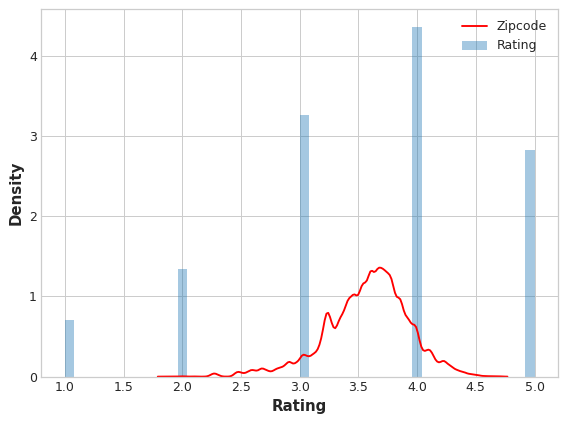

In [ ]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

The distribution of the encoded Zipcode feature roughly follows the distribution of the actual ratings, meaning that movie-watchers differed enough in their ratings from zipcode to zipcode that our target encoding was able to capture useful information.